# Planning the spanish economy 

Let's begin importing the data in a dictionary for the periods we want to plan. The data has been saved from the excel files using the ``save_data.py`` script.

In [37]:
from pathlib import Path
from pickle import load

import numpy as np

from cybersyn import Economy, Ecology, TargetEconomy, TargetEcology


with Path('data', 'economy.pkl').open('rb') as f:
    economy_dict = load(f)
    economy = Economy(**economy_dict)

with Path('data', 'target_economy.pkl').open('rb') as f:
    target_economy_dict = load(f)
    target_economy = TargetEconomy(**target_economy_dict)

with Path('data', 'ecology.pkl').open('rb') as f:
    ecology_dict = load(f)
    ecology = Ecology(**ecology_dict)

with Path('data', 'target_ecology.pkl').open('rb') as f:
    target_ecology_dict = load(f)
    target_ecology = TargetEcology(**target_ecology_dict)

The data is aggregated into 110 products and 81 sectors:

In [38]:
economy.product_names[:5]

['1. Products of agriculture',
 '2. Live animals and animal products',
 '3. Agricultural and animal husbandry services',
 '4. Products of forestry, logging and related services',
 '5 .Fish and other fishing products; aquaculture products; support services to fishing']

In [39]:
economy.product_names[-5:]

['106. Services furnished by membership organisations',
 '107. Repair services of computers and personal and household goods',
 '108. Other personal services',
 '109. Services of households as employers; undifferentiated goods and services produced by households for own use',
 '110. Services provided by extraterritorial organisations and bodies']

In [40]:
economy.sector_names[-5:]

['Activities of membership organisations',
 'Repair of computers and personal and household goods',
 'Other personal service activities',
 'Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use',
 'Activities of extra-territorial organisations and bodies']

## The plan

We will plan the economy for 6 periods with a horizon of 2 periods and revising the plan after 1 period (apply one periods and discard the other).

In [41]:
from cybersyn import OptimizePlan

periods = 6
horizon_periods = 2
revise_periods = 1

plan = OptimizePlan(periods = periods,
                    horizon_periods = horizon_periods, 
                    revise_periods = revise_periods,
                    economy = economy,
                    ecology = ecology
                    )

init_excess_prod = target_economy.domestic[0] / 12
init_excess_prod = np.zeros(economy.products)
init_export_deficit = 0

planned = plan(target_economy, target_ecology, init_excess_prod, init_export_deficit)


In [42]:
activity = np.array(planned.activity).T
production = np.array(planned.production).T
surplus = np.array(planned.surplus).T
total_import = np.array(planned.total_import).T
export_deficit = np.array(planned.export_deficit)
worked_hours = np.array(planned.worked_hours)

## Visualizing the results

In [43]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

colors = plt.cm.nipy_spectral(np.linspace(0, 1, economy.products))

We planned for 3 years and the interpolation between them (mYEAR).

In [44]:
periods = ['2016', 'm2016', '2017', 'm2017', '2018', 'm2018', '2019']

### Production unit activity 

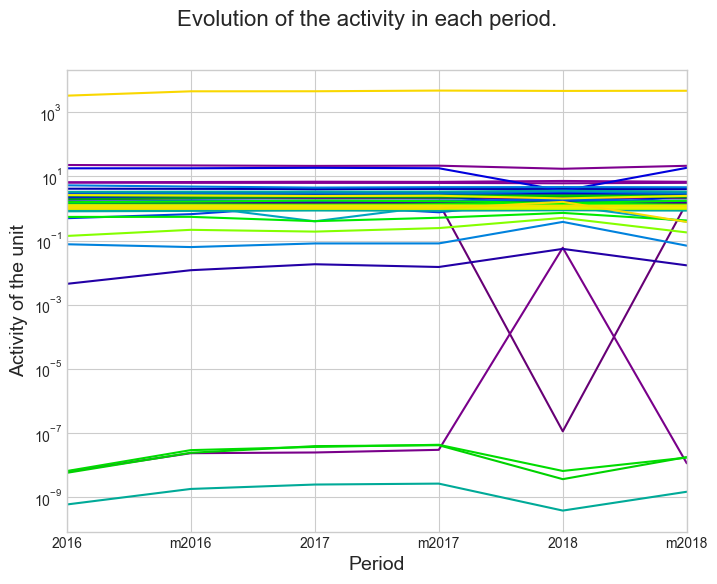

In [45]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of the activity in each period.', size = 16)

for i in range(economy.sectors):
    ax.plot(periods[: plan.periods], activity[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Activity of the unit', size = 14)
ax.set_yscale('log')

plt.savefig(Path('figures', 'unit_activity.png'))

### Production

The planned activity of each sector provides the planned production

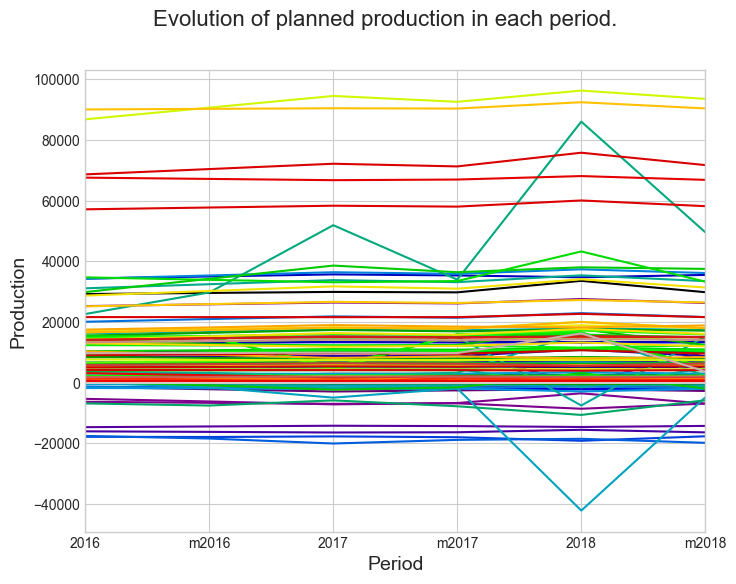

In [46]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of planned production in each period.', size = 16)

for i in range(economy.products):
    ax.plot(periods[: plan.periods], production[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Production', size = 14)

plt.savefig(Path('figures', 'planned_prod.png'))

Note that some periods have negative production. This means that either we are consuming excess goods from previous periods or, most likely, we are importing those producs.

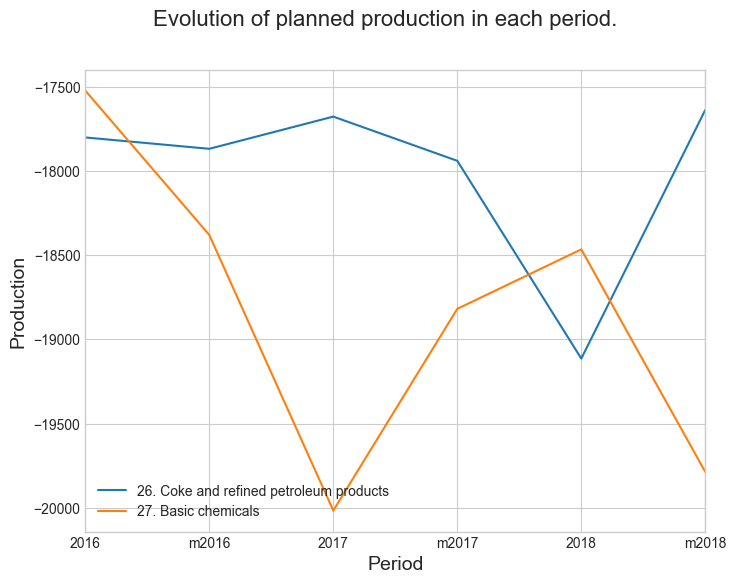

In [47]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of planned production in each period.', size = 16)

ax.plot(periods[: plan.periods], production[25, :], label=economy.product_names[25])
ax.plot(periods[: plan.periods], production[26, :], label='27. Basic chemicals')

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Production', size = 14)
ax.legend(loc="lower left")

### Excess production

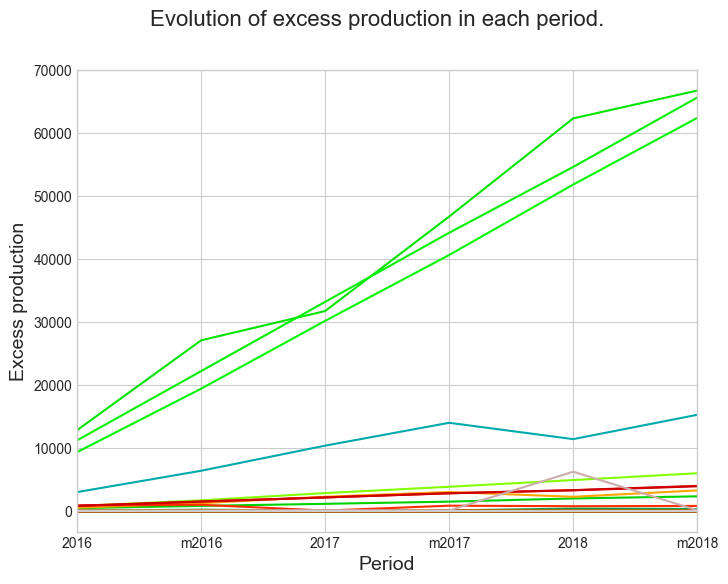

In [48]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of excess production in each period.', size = 16)

for i in range(economy.products):
    ax.plot(periods[: plan.periods], surplus[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Excess production', size = 14)

plt.savefig(Path('figures', 'excess_prod.png'))

Note how the excess of some products keeps rising

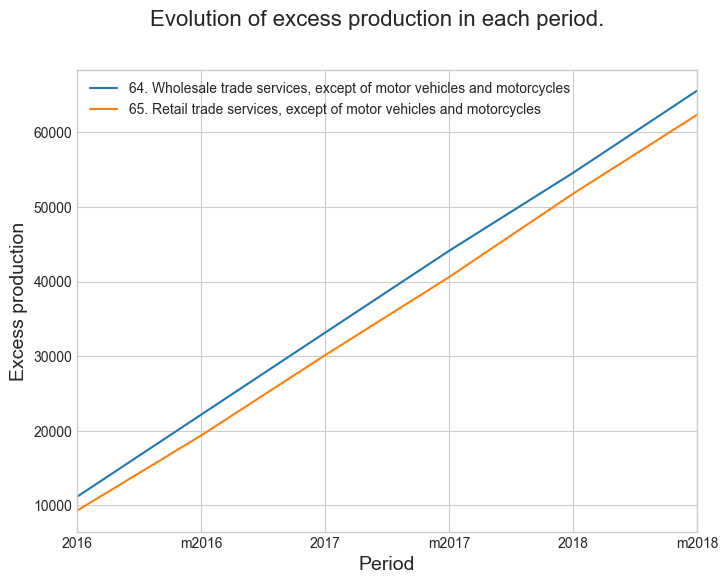

In [49]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of excess production in each period.', size = 16)

ax.plot(periods[: plan.periods], surplus[63, :], label=economy.product_names[63])
ax.plot(periods[: plan.periods], surplus[64, :], label=economy.product_names[64])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Excess production', size = 14)
ax.legend()

While others, like excess food, remains almost zero.

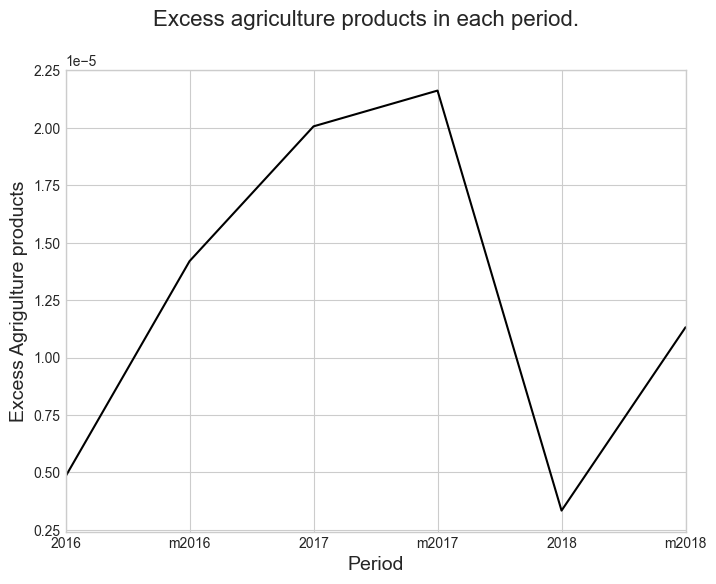

In [50]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle(r'Excess agriculture products in each period.', size = 16)

ax.plot(periods[: plan.periods], surplus[0, :], c=colors[0, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel("Excess Agrigulture products", size = 14)

plt.savefig(Path('figures', 'excess_agriculture.png'))

### Imported goods

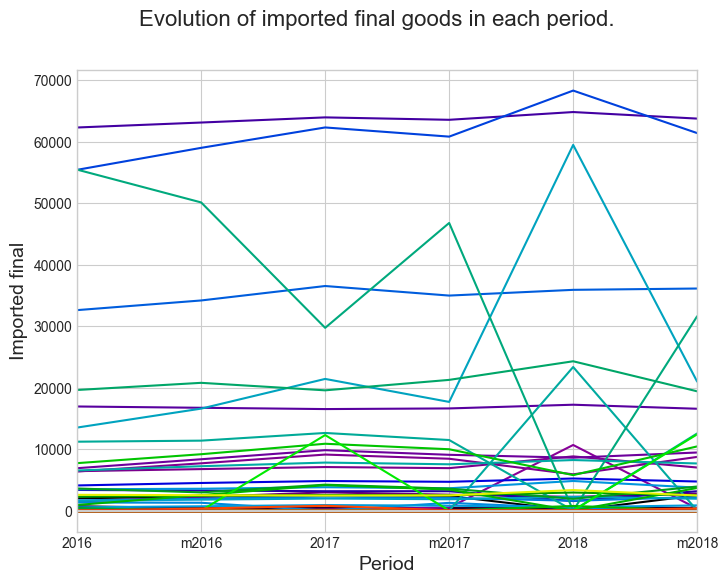

In [51]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of imported final goods in each period.', size = 16)

for i in range(economy.products):
    ax.plot(periods[: plan.periods], total_import[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Imported final', size = 14)

plt.savefig(Path('figures', 'planned_prod.png'))

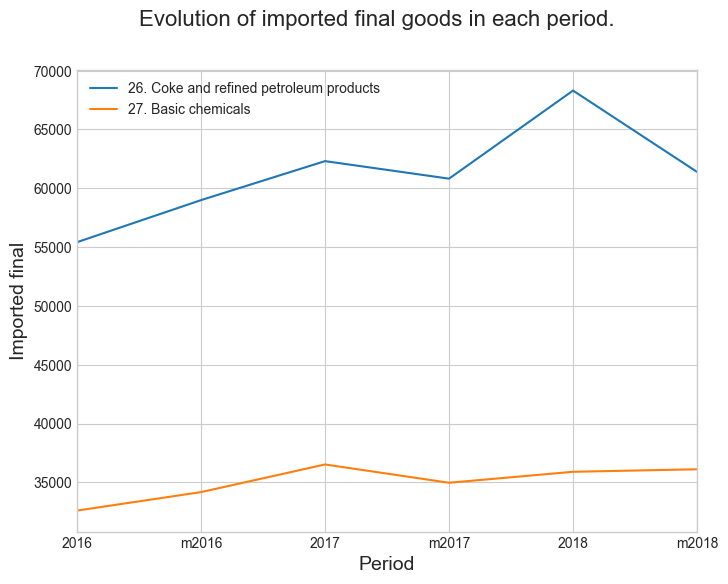

In [52]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of imported final goods in each period.', size = 16)

ax.plot(periods[: plan.periods], total_import[25, :], label=economy.product_names[25])
ax.plot(periods[: plan.periods], total_import[26, :], label='27. Basic chemicals')

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Imported final', size = 14)
ax.legend(loc="upper left")

### Export deficit

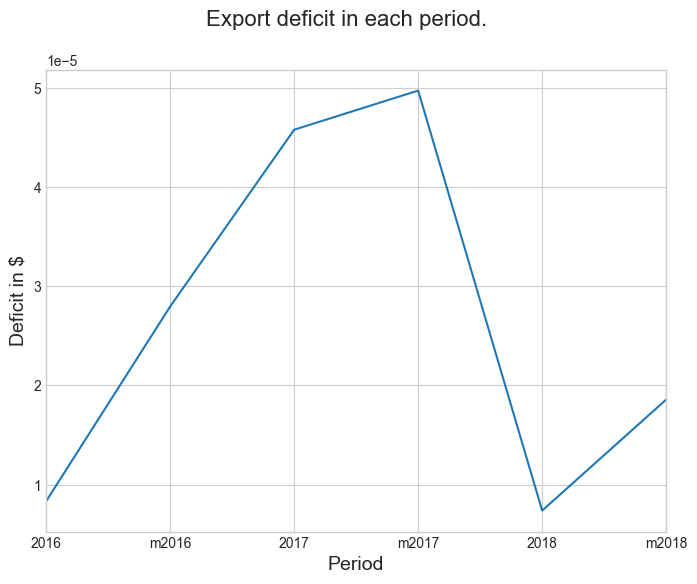

In [53]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Export deficit in each period.', size = 16)

ax.plot(periods[: plan.periods], export_deficit)

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Deficit in $', size = 14)

plt.savefig(Path('figures', 'export_deficit.png'))

### Total worked hours

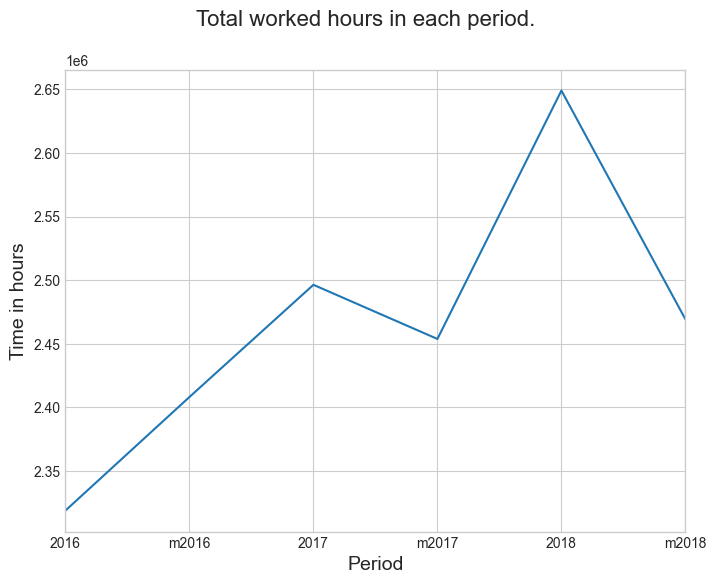

In [54]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Total worked hours in each period.', size = 16)

ax.plot(periods[: plan.periods], worked_hours)

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Time in hours', size = 14)

plt.savefig(Path('figures', 'worked_hours.png'))